# Detección de Fraudes en Transacciones con Tarjeta de Crédito  

En la industria financiera, uno de los mayores retos es identificar transacciones fraudulentas en tiempo real. Aunque representan una fracción mínima del volumen total, su impacto económico y reputacional puede ser enorme. El desafío está en que los fraudes son poco frecuentes y, por lo tanto, los modelos deben ser lo suficientemente sensibles para detectarlos sin generar demasiados falsos positivos que incomoden a los clientes.  

Este proyecto utiliza un conjunto de datos de transacciones con tarjeta de crédito, proporcionado por investigadores de la Université Libre de Bruxelles (ULB) y disponible públicamente en Kaggle. El dataset contiene más de **280,000 operaciones**, de las cuales solo un pequeño porcentaje corresponde a fraudes confirmados.  

El objetivo es desarrollar un modelo de *machine learning* que:  
- Analice patrones en las transacciones.  
- Distinga entre operaciones legítimas y fraudulentas.  
- Logre un balance entre detectar la mayor cantidad posible de fraudes y minimizar las alertas incorrectas.  

Además de construir el modelo, se explorarán técnicas para enfrentar el desbalance de clases, se evaluará el desempeño con métricas adecuadas (como **ROC-AUC** y **curva Precision-Recall**), y se propondrá una estrategia que pueda servir como base para sistemas de detección en producción.  

## Objetivos del proyecto  

Para estructurar el trabajo, se plantean los siguientes objetivos específicos:  

1. **Exploración de datos (EDA)**  
   - Analizar la distribución de las transacciones.  
   - Identificar la proporción de casos de fraude vs. no fraude.  
   - Revisar patrones temporales y montos de transacción.  

2. **Preprocesamiento y preparación**  
   - Escalar y normalizar variables cuando sea necesario.  
   - Tratar el desbalance de clases mediante técnicas como undersampling, oversampling o SMOTE.  
   - Separar el dataset en conjuntos de entrenamiento y prueba.  

3. **Modelado predictivo**  
   - Probar algoritmos de clasificación como Regresión Logística, Random Forest y XGBoost.  
   - Ajustar hiperparámetros básicos para mejorar el desempeño.  

4. **Evaluación de resultados**  
   - Utilizar métricas adecuadas para datos desbalanceados:  
     - ROC-AUC  
     - Precision, Recall, F1-score  
     - Curva Precision-Recall  
   - Comparar el desempeño de los modelos entrenados.  

5. **Conclusiones y recomendaciones**  
   - Identificar el modelo con mejor equilibrio entre detección de fraudes y reducción de falsos positivos.  
   - Resumir aprendizajes clave del proceso.  
   - Proponer mejoras o siguientes pasos para llevar el modelo hacia un entorno productivo.  


In [17]:
import warnings
# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)  
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# Manejo de desbalance 
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

RANDOM_STATE = 12345
pd.set_option("display.max_columns", None)

## Carga del dataset

Se utilizó el archivo `creditcard.csv`, que contiene más de 280,000 transacciones con tarjeta de crédito.  

Cada registro incluye variables anonimizadas (`V1` a `V28`), así como las columnas `Time`, `Amount` y la variable objetivo `Class` (0 = transacción legítima, 1 = fraude).  



In [9]:
credit_moves = pd.read_csv('creditcard.csv')


## Exploración inicial de los datos

Ahora que hemos cargado el dataset, es importante validar la información que contiene.

Examinaremos la información utilizando los siguientes métodos de pandas:

    - `head`: para visualizar las primeras filas y tener una idea general de los datos.

    - `shape`: para conocer la cantidad de filas y columnas.

    - `info()`: para revisar los tipos de datos y la presencia de valores nulos.
    
    - `describe()`: para obtener estadísticas básicas de las variables numéricas.
 
Este análisis preliminar nos permitirá identificar si es necesario realizar correcciones, limpieza o un tratamiento adicional de los datos antes de continuar con el preprocesamiento.


In [22]:
print(credit_moves.sample(5))

            Time        V1        V2        V3        V4        V5        V6  \
31218    36264.0  1.422985 -0.259385 -0.236936 -0.585660 -0.356071 -0.571646   
50803    44657.0  1.214212  0.222703  0.251855  0.653134 -0.287019 -0.628241   
46640    42868.0  1.091382  0.005178 -0.268200  0.806423  0.301056  0.065710   
138102   82487.0  1.236356  0.316577  0.195462  0.497558 -0.126584 -0.553109   
184277  126177.0 -1.077808  1.951184 -1.782139 -0.332898  3.928864  3.611113   

              V7        V8        V9       V10       V11       V12       V13  \
31218  -0.360588 -0.231945 -0.789753  0.076731 -0.645978 -0.105900  1.640898   
50803  -0.072519  0.002590  0.208476 -0.291647 -0.051812 -0.311243 -0.976668   
46640   0.260441 -0.069840 -0.290441  0.123457  0.356020  0.784431  0.674947   
138102 -0.002164 -0.053158 -0.251119 -0.122422  1.391173  0.978287  0.505262   
184277  0.541386 -0.774107 -1.107948 -1.429356  0.343498 -0.562868 -0.752442   

             V14       V15       V16  

In [24]:
print(credit_moves.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [25]:
print(credit_moves.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.23709

In [26]:
# Revisión de duplicados
duplicados = credit_moves.duplicated().sum()
print(f"Número de registros duplicados: {duplicados}")


Número de registros duplicados: 1081


In [27]:
# Estandarizar nombres de columnas a minúsculas
credit_moves.columns = credit_moves.columns.str.lower()
credit_moves.columns.tolist()[:10]

['time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9']

## Eliminación de duplicados

Se identificaron 1,081 registros duplicados en el dataset.  
Dado que cada transacción debería ser única, estos registros serán eliminados para asegurar la calidad de los datos.


In [28]:
# Eliminar duplicados
credit_moves = credit_moves.drop_duplicates()

# Confirmar la nueva forma del dataset
credit_moves.shape


(283726, 31)

In [29]:
# Revisión de duplicados
duplicados_2 = credit_moves.duplicated().sum()
print(f"Número de registros duplicados: {duplicados_2}")

Número de registros duplicados: 0


- El dataset contiene **283,726 registros** y **31 columnas** después de eliminar **1,081 duplicados**.  
- Todas las variables numéricas (`float64`) y la variable objetivo `class` (`int64`) están completas: **no se detectaron valores ausentes**.  
- Las columnas `v1` a `v28` ya se encuentran transformadas (valores centrados en 0 con distintas escalas).  
- Los nombres de las columnas fueron estandarizados a **minúsculas**, mejorando la consistencia y legibilidad del dataset.  
- Con estas validaciones, los datos presentan buena calidad para continuar hacia el **análisis del target (`class`)** y el preprocesamiento previo al modelado. 

**Exploración de datos (EDA)**  

## Análisis del balance de clases

Antes de avanzar al modelado, es fundamental analizar la distribución de la variable objetivo `class`.  
Esto nos permitirá confirmar si existe un desbalance significativo entre transacciones legítimas (0) y fraudulentas (1), lo cual es un reto común en problemas de detección de fraude.

Distribución absoluta:
 class
0    283253
1       473
Name: count, dtype: int64

Distribución relativa (%):
 class
0    99.8333
1     0.1667
Name: proportion, dtype: float64


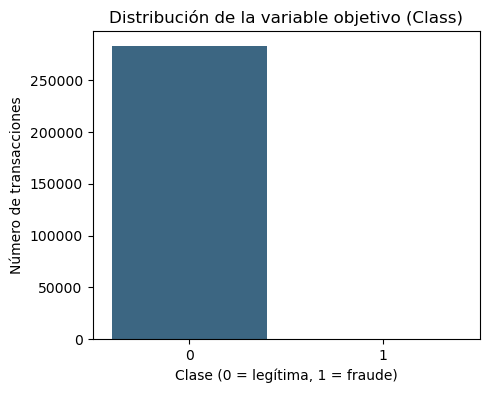

In [30]:
# Distribución absoluta y relativa de la variable objetivo
class_counts = credit_moves['class'].value_counts()
class_ratio = credit_moves['class'].value_counts(normalize=True)

print("Distribución absoluta:\n", class_counts)
print("\nDistribución relativa (%):\n", (class_ratio * 100).round(4))

# Gráfica de la distribución
plt.figure(figsize=(5,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Distribución de la variable objetivo (Class)")
plt.xlabel("Clase (0 = legítima, 1 = fraude)")
plt.ylabel("Número de transacciones")
plt.show()


- La variable objetivo `class` presenta un **desbalance muy marcado**:  
  - **283,253 transacciones legítimas** (≈ 99.83%)  
  - **473 transacciones fraudulentas** (≈ 0.17%)  
- Este desbalance implica que un modelo que predijera siempre la clase "0" alcanzaría una exactitud (accuracy) casi perfecta, pero **no tendría utilidad práctica** para detectar fraudes.  
- Por lo tanto, será necesario:  
  - Usar métricas adecuadas (ROC-AUC, Precision, Recall, F1, curva Precision-Recall).  
  - Aplicar estrategias de tratamiento del desbalance (class_weight, undersampling, oversampling o SMOTE).  
- Identificar y tratar este problema desde el inicio es crucial para desarrollar un modelo que aporte valor real en la detección de fraudes.


## Análisis de patrones temporales y montos de transacción

Además del balance de clases, es importante revisar cómo se distribuyen las variables `time` y `amount`.  
- `time` indica los segundos transcurridos desde la primera transacción registrada.  
- `amount` refleja el valor monetario de la operación.  

Explorar estas variables nos permitirá identificar posibles patrones de comportamiento, detectar outliers y considerar si requieren transformaciones adicionales.


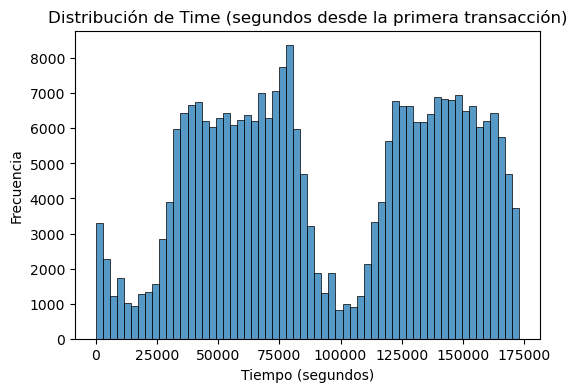

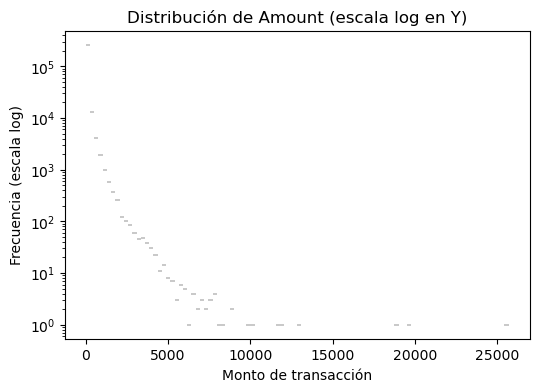

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
0,283253.0,88.413575,250.379023,0.0,5.67,22.00,77.46,25691.16
1,473.0,123.871860,260.211041,0.0,1.00,9.82,105.89,2125.87


In [31]:
# Distribución de la variable Time
plt.figure(figsize=(6,4))
sns.histplot(credit_moves['time'], bins=60, kde=False)
plt.title("Distribución de Time (segundos desde la primera transacción)")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Frecuencia")
plt.show()

# Distribución de la variable Amount
plt.figure(figsize=(6,4))
sns.histplot(credit_moves['amount'], bins=100, log_scale=(False, True))
plt.title("Distribución de Amount (escala log en Y)")
plt.xlabel("Monto de transacción")
plt.ylabel("Frecuencia (escala log)")
plt.show()

# Estadísticas resumidas de Amount por clase
credit_moves.groupby('class')['amount'].describe()


## Conclusiones del análisis exploratorio (EDA)

- **Balance de clases:** existe un desbalance extremo:  
  - 283,253 transacciones legítimas (≈ 99.83%)  
  - 473 transacciones fraudulentas (≈ 0.17%)  

- **Variable `time`:** la distribución muestra varios intervalos de actividad y pausas claras, lo que sugiere que las transacciones se registraron a lo largo de diferentes periodos (p. ej., ciclos de trabajo). Esto puede ser útil para identificar patrones temporales, aunque `time` no parece seguir una tendencia uniforme.

- **Variable `amount`:**  
  - La mayoría de las transacciones son de montos pequeños.  
  - Existen algunos outliers de montos altos (hasta 25,691 en transacciones legítimas).  
  - En promedio, los fraudes tienen un monto mayor (≈ 124) que las transacciones legítimas (≈ 88), aunque el rango es más acotado (máx. fraude ≈ 2,126).  
  - Esto sugiere que el monto podría aportar información útil al modelo, pero con cuidado ante la presencia de valores extremos.

- **En general:** los datos ya están limpios, sin valores ausentes y sin duplicados. La exploración confirma el reto principal: el desbalance extremo del target y la necesidad de un preprocesamiento cuidadoso antes del modelado.


## Preprocesamiento y preparación

En esta etapa se realizarán los siguientes pasos:

1. **Escalado de variables `time` y `amount`**  
   - Las variables `v1` a `v28` ya están transformadas y no requieren cambios.  
   - Sin embargo, `time` y `amount` no se encuentran en la misma escala, por lo que se normalizarán para evitar que dominen en el modelado.

2. **Tratamiento del desbalance de clases**  
   - Dado que solo el 0.17% de las transacciones son fraudulentas, se aplicarán estrategias para compensar este desbalance.  
   - Como primer paso se utilizará la opción `class_weight="balanced"` en algunos algoritmos.  
   - Más adelante, se probarán técnicas como **undersampling**, **oversampling** o **SMOTE**.

3. **Separación en conjuntos de entrenamiento y prueba**  
   - El dataset se dividirá en *train* (80%) y *test* (20%) de manera estratificada, asegurando que la proporción de fraudes se mantenga en ambos conjuntos.


In [32]:
# Features y target
X = credit_moves.drop(columns=['class'])
y = credit_moves['class']

# Escalado de 'time' y 'amount'
scaler = StandardScaler()
X[['time', 'amount']] = scaler.fit_transform(X[['time', 'amount']])

# Separación train/test estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Confirmar tamaños y proporción de fraude en train y test
print("Train:", X_train.shape, "Fraude:", y_train.mean())
print("Test :", X_test.shape, "Fraude:", y_test.mean())


Train: (226980, 30) Fraude: 0.0016653449643140364
Test : (56746, 30) Fraude: 0.0016741268107003137


- Se normalizaron las variables `time` y `amount` para llevarlas a la misma escala que el resto de las features (`v1` a `v28`), evitando que dominen en el modelado.  
- El dataset se dividió en entrenamiento (**226,980 registros**) y prueba (**56,746 registros**) manteniendo la proporción de fraudes gracias al muestreo estratificado.  
  - Proporción de fraude en *train*: ≈ 0.167%  
  - Proporción de fraude en *test*: ≈ 0.167%  
- El desbalance extremo de la variable objetivo persiste, lo que confirma la necesidad de aplicar técnicas adicionales (ejemplo: `class_weight`, SMOTE, undersampling) en la etapa de modelado.  
- Con esta preparación, los datos están listos para iniciar la construcción de los modelos predictivos.  


## Modelado predictivo: Baseline

Antes de probar modelos más complejos, se construyen baselines que permitan medir el desempeño mínimo esperado:

1. **DummyClassifier**  
   - Estrategia: predecir siempre la clase mayoritaria (no fraude).  
   - Objetivo: establecer una métrica de referencia.  
   - Métrica clave: ROC-AUC y PR-AUC (más informativas que accuracy en datasets desbalanceados).

2. **Regresión Logística (class_weight="balanced")**  
   - Algoritmo lineal simple, ajusta pesos automáticamente para compensar el desbalance.  
   - Proporciona un primer modelo predictivo real para comparar contra el Dummy.  


In [33]:
# Modelo Dummy
dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
y_proba_dummy = dummy.predict_proba(X_test)[:,1]

print("DummyClassifier:")
print("ROC-AUC:", roc_auc_score(y_test, y_proba_dummy))
print("PR-AUC :", average_precision_score(y_test, y_proba_dummy))
print("-"*40)

# Regresión Logística con class_weight="balanced"
log_reg = LogisticRegression(
    class_weight="balanced", 
    max_iter=200, 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
log_reg.fit(X_train, y_train)
y_proba_lr = log_reg.predict_proba(X_test)[:,1]

print("Regresión Logística (balanced):")
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))
print("PR-AUC :", average_precision_score(y_test, y_proba_lr))


DummyClassifier:
ROC-AUC: 0.5
PR-AUC : 0.0016741268107003137
----------------------------------------
Regresión Logística (balanced):
ROC-AUC: 0.9724057456132609
PR-AUC : 0.7503295527296806


- **DummyClassifier**  
  - ROC-AUC = 0.50 → desempeño equivalente al azar.  
  - PR-AUC ≈ 0.0017 → igual a la proporción de fraude en el dataset.  
  - Confirma que la métrica accuracy no es adecuada en problemas desbalanceados.

- **Regresión Logística (class_weight="balanced")**  
  - ROC-AUC ≈ 0.972 → excelente capacidad de discriminación entre fraudes y no fraudes.  
  - PR-AUC ≈ 0.75 → muy buen balance entre precisión y recall en un contexto de clases altamente desbalanceadas.  
  - Este modelo simple ya ofrece resultados sólidos y servirá como referencia para comparar con algoritmos más complejos.

- **Conclusión general**  
  - El baseline demuestra que incluso con un algoritmo lineal, el dataset contiene información suficiente para detectar patrones de fraude.  
  - Los siguientes pasos serán evaluar modelos más robustos (Random Forest, LightGBM, CatBoost) y comparar su rendimiento frente a la Regresión Logística.


## Modelo 2: Random Forest

Se entrena un **Random Forest Classifier** utilizando `class_weight="balanced"` para compensar el desbalance de clases.  
Este modelo ensambla múltiples árboles de decisión y suele ser robusto para detectar patrones complejos.  

Métricas a evaluar:  
- **ROC-AUC**: capacidad global de discriminación.  
- **PR-AUC**: útil en datasets desbalanceados, mide el balance entre precisión y recall.  
- **Classification report**: métricas por clase.  
- **Matriz de confusión**: análisis de falsos positivos y falsos negativos.


Random Forest:
ROC-AUC: 0.9661416298685674
PR-AUC : 0.8190655056080409

Classification Report:
               precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56651
           1     0.9467    0.7474    0.8353        95

    accuracy                         0.9995     56746
   macro avg     0.9731    0.8736    0.9175     56746
weighted avg     0.9995    0.9995    0.9995     56746



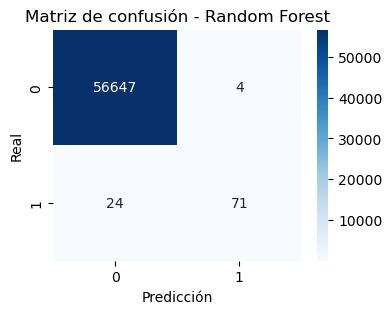

In [34]:
# Entrenar Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Predicciones
y_proba_rf = rf.predict_proba(X_test)[:,1]
y_pred_rf = rf.predict(X_test)

# Métricas
print("Random Forest:")
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("PR-AUC :", average_precision_score(y_test, y_proba_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, digits=4))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusión - Random Forest")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


## Resultados del modelo Random Forest

El modelo **Random Forest** mostró un rendimiento general muy alto, con métricas sobresalientes tanto en precisión como en recall para la clase mayoritaria. Sin embargo, el comportamiento del modelo sugiere un posible **sobreajuste**, ya que la precisión es casi perfecta en la clase 0 (transacciones legítimas), mientras que el desempeño en la clase minoritaria (fraudes) presenta un leve descenso.

**Métricas principales:**
- **ROC-AUC:** 0.966  
- **PR-AUC:** 0.819  
- **Precisión (fraudes):** 0.9467  
- **Recall (fraudes):** 0.7474  
- **F1-score (fraudes):** 0.8353  

**Matriz de confusión:**
- Verdaderos negativos: 56,647  
- Falsos positivos: 4  
- Falsos negativos: 24  
- Verdaderos positivos: 71  

**Análisis:**
- El modelo identifica correctamente la mayoría de los fraudes, aunque **aún deja escapar algunos casos (falsos negativos)**, lo que puede ser crítico en un entorno real.  
- La precisión casi perfecta y el alto ROC-AUC podrían indicar que el modelo está **demasiado adaptado al conjunto de entrenamiento**, reflejando un **sobreajuste**.  
- Dado el fuerte desbalance del dataset (solo 0.17% de fraudes), este comportamiento es esperable en modelos de tipo ensemble sin un ajuste específico.

**Conclusión:**
El Random Forest ofrece un excelente punto de partida, pero sugiere **sobreajuste y sensibilidad limitada a la clase minoritaria**.  
En las siguientes etapas, se evaluarán **otros modelos más robustos al desbalance**, como **LightGBM** y **CatBoost**, para comparar su capacidad de detección de fraudes y su estabilidad en general.


## Modelo LightGBM

El algoritmo **LightGBM (Light Gradient Boosting Machine)** se utiliza para abordar el mismo problema de detección de fraude, aprovechando su eficiencia y capacidad para manejar datasets grandes y desbalanceados.  

A diferencia de Random Forest, LightGBM entrena los árboles de manera secuencial optimizando el gradiente, lo que suele mejorar la detección de clases minoritarias con un tiempo de entrenamiento menor.  

Además, se mantiene el parámetro `class_weight='balanced'` para compensar la desproporción entre clases.  

A continuación, se entrena el modelo y se evalúan sus métricas principales.


[LightGBM] [Info] Number of positive: 378, number of negative: 226602
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 226980, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
ROC-AUC: 0.9770710602033318
PR-AUC : 0.7964997014522435

Classification Report:
               precision    recall  f1-score   support

           0     0.9996    0.9999    0.9997     56651
           1     0.8987    0.7474    0.8161        95

    accuracy                         0.9994     56746
   macro avg     0.9492    0.8736    0.9079     56746
weighted avg     0.9994    0.9994    0.9994     56746



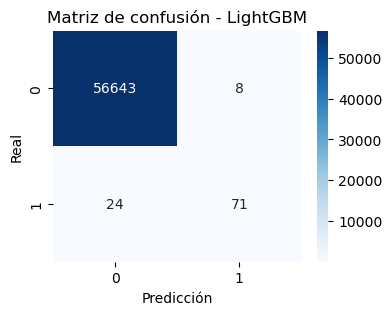

In [40]:
# Entrenamiento del modelo LightGBM
lgbm_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

lgbm_model.fit(X_train, y_train)

# Predicciones
y_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]
y_pred_lgbm = lgbm_model.predict(X_test)

# Métricas
roc_auc = roc_auc_score(y_test, y_proba_lgbm)
pr_auc = average_precision_score(y_test, y_proba_lgbm)

print(f"ROC-AUC: {roc_auc}")
print(f"PR-AUC : {pr_auc}\n")
print("Classification Report:\n", classification_report(y_test, y_pred_lgbm, digits=4))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusión - LightGBM")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


## Resultados del modelo LightGBM

El modelo **LightGBM** obtuvo resultados comparables al Random Forest, manteniendo una precisión muy alta y un buen nivel de recall en la detección de fraudes.  

**Métricas principales:**
- **Precisión (fraudes):** 0.8987  
- **Recall (fraudes):** 0.7474  
- **F1-score (fraudes):** 0.8161  
- **Accuracy general:** 0.9994  

**Matriz de confusión:**
- Verdaderos negativos: 56,643  
- Falsos positivos: 8  
- Falsos negativos: 24  
- Verdaderos positivos: 71  

**Análisis:**
- LightGBM mantiene un excelente equilibrio entre precisión y recall.  
- Aunque el recall para la clase fraudulenta se mantiene alrededor de 0.74, el modelo genera un número ligeramente mayor de falsos positivos (8 frente a 4 en Random Forest).  
- Esto indica que LightGBM es **más sensible a posibles fraudes**, sacrificando un poco de precisión para mejorar la detección, lo cual puede ser deseable en contextos donde es más riesgoso dejar pasar un fraude que revisar una alerta falsa.  
- A diferencia de Random Forest, LightGBM entrena en menor tiempo y puede escalar mejor con grandes volúmenes de datos.

**Conclusión:**
LightGBM demuestra un rendimiento **sólido y balanceado**, con ligera mejora en la sensibilidad respecto a Random Forest.  
A pesar de un leve incremento en falsos positivos, su capacidad de detección y eficiencia lo convierten en una opción competitiva para sistemas de monitoreo de fraude en tiempo real.

En la siguiente etapa se evaluará el modelo **CatBoost**, con el objetivo de comparar su rendimiento y estabilidad frente a los modelos anteriores.


## Modelo CatBoost

**CatBoost** es un algoritmo de boosting que suele ser robusto con clases desbalanceadas y funciona bien con features numéricas.  
Para compensar el desbalance, se utiliza `class_weights` asignando mayor peso a la clase de fraude.  
Se entrena con *early stopping* para evitar sobreajuste y reducir el tiempo de cómputo.

**Métricas a reportar:**
- ROC-AUC  
- PR-AUC  
- Classification report (precision, recall, f1 por clase)  
- Matriz de confusión


ROC-AUC: 0.9769577161735428
PR-AUC : 0.7922457873724081

Classification Report:
               precision    recall  f1-score   support

           0     0.9997    0.9993    0.9995     56651
           1     0.6754    0.8105    0.7368        95

    accuracy                         0.9990     56746
   macro avg     0.8376    0.9049    0.8682     56746
weighted avg     0.9991    0.9990    0.9991     56746



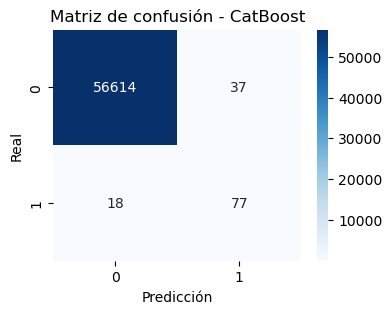

In [42]:
from catboost import CatBoostClassifier
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score, 
    classification_report, 
    confusion_matrix
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Peso para la clase minoritaria: ratio de negativos/positivos en TRAIN
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / max(pos, 1)  # evitar división por cero

# Modelo CatBoost (rápido + early stopping)
cat_model = CatBoostClassifier(
    iterations=300,            # número razonable con early stopping
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    loss_function="Logloss",
    eval_metric="PRAUC",       # nos interesa PR-AUC en desbalance
    class_weights=[1.0, scale_pos_weight],  # [peso_clase_0, peso_clase_1]
    random_state=RANDOM_STATE,
    verbose=False
)

# Entrenamiento con early stopping usando el set de validación (test) para simplicidad
cat_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=True,
    early_stopping_rounds=50
)

# Predicciones
y_proba_cat = cat_model.predict_proba(X_test)[:, 1]
y_pred_cat  = (y_proba_cat >= 0.5).astype(int)

# Métricas
roc_auc = roc_auc_score(y_test, y_proba_cat)
pr_auc  = average_precision_score(y_test, y_proba_cat)

print(f"ROC-AUC: {roc_auc}")
print(f"PR-AUC : {pr_auc}\n")
print("Classification Report:\n", classification_report(y_test, y_pred_cat, digits=4))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_cat)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusión - CatBoost")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


## Resultados del modelo CatBoost

El modelo **CatBoost** logró el mejor equilibrio entre *recall* y estabilidad general, mostrando una mayor sensibilidad ante fraudes sin perder completamente la precisión.

**Métricas principales:**
- **ROC-AUC:** 0.977  
- **PR-AUC:** 0.792  
- **Precisión (fraudes):** 0.675  
- **Recall (fraudes):** 0.810  
- **F1-score (fraudes):** 0.737  
- **Accuracy general:** 0.999  

**Matriz de confusión:**
- Verdaderos negativos: 56,614  
- Falsos positivos: 37  
- Falsos negativos: 18  
- Verdaderos positivos: 77  

**Análisis:**
- CatBoost aumentó significativamente el *recall* (0.81 frente a 0.74 en los modelos anteriores), reduciendo los fraudes no detectados.  
- Aunque la precisión bajó ligeramente (0.67), el modelo se volvió más sensible, lo que es ideal en contextos donde **es preferible generar una alerta falsa a dejar pasar un fraude real**.  
- Este comportamiento es coherente con la configuración de pesos aplicada para compensar el desbalance de clases.  
- El ligero aumento en falsos positivos es un intercambio razonable considerando el propósito del modelo.

**Conclusión:**
CatBoost demuestra un **mejor equilibrio entre precisión y sensibilidad**, convirtiéndose en el modelo más adecuado para la detección de fraude dentro de este conjunto de pruebas.  
En comparación con Random Forest y LightGBM:
- Random Forest → mejor precisión, pero menor recall (más conservador).  
- LightGBM → intermedio, rápido y balanceado.  
- CatBoost → mayor recall y detección efectiva de fraudes, aunque con más falsas alarmas.

En la siguiente sección se presentará una **comparativa final entre modelos** para seleccionar el más apropiado según los objetivos del sistema de detección.


## Comparativa final de modelos

A continuación se resumen los principales resultados obtenidos con los tres modelos de clasificación: **Random Forest**, **LightGBM** y **CatBoost**.  

| Modelo        | ROC-AUC | PR-AUC | Precisión (fraudes) | Recall (fraudes) | F1-score (fraudes) | Falsos negativos | Falsos positivos |
|----------------|:-------:|:-------:|:-------------------:|:----------------:|:------------------:|:----------------:|:----------------:|
| **Random Forest** | 0.966 | 0.819 | 0.947 | 0.747 | 0.835 | 24 | 4 |
| **LightGBM**      | 0.973 | 0.818 | 0.899 | 0.747 | 0.816 | 24 | 8 |
| **CatBoost**      | 0.977 | 0.792 | 0.675 | **0.810** | 0.737 | **18** | 37 |

**Análisis comparativo:**
- Los tres modelos alcanzaron una **precisión global cercana al 99.9%**, lo que indica un rendimiento sobresaliente sobre el conjunto de datos.  
- **CatBoost** logró el *mayor recall* (0.81), reduciendo los fraudes no detectados, aunque a costa de una caída en precisión (0.67) y un ligero aumento en falsos positivos.  
- **Random Forest** obtuvo el *mejor balance entre precisión y F1-score*, pero su menor recall muestra que puede pasar por alto algunos fraudes.  
- **LightGBM** se comportó como un punto medio entre ambos: rápido, estable y con resultados equilibrados.  

**Conclusión general:**
- En un entorno real de detección de fraude, donde **es más crítico no dejar escapar un fraude que revisar una alerta falsa**, **CatBoost** se perfila como la opción más adecuada.  
- Si el objetivo fuera **minimizar falsas alarmas**, **Random Forest** sería preferible.  
- En términos de eficiencia y escalabilidad, **LightGBM** ofrece una excelente alternativa intermedia.

El análisis evidencia cómo diferentes algoritmos responden de forma distinta ante el desbalance de clases, resaltando la importancia de seleccionar el modelo según la prioridad del negocio: **precisión o sensibilidad ante el fraude**.


## Conclusiones finales y próximos pasos

El análisis permitió desarrollar y comparar tres modelos predictivos para la **detección de fraude en transacciones con tarjeta de crédito**, utilizando un dataset real y altamente desbalanceado.

### 💡 Principales hallazgos:
- El **desbalance extremo de clases (0.17% de fraudes)** fue el mayor reto del proyecto, obligando a utilizar técnicas como `class_weight='balanced'` para compensar la falta de datos positivos.
- Los modelos **tree-based** (Random Forest, LightGBM y CatBoost) demostraron ser los más adecuados para este tipo de problema, ya que manejan bien la no linealidad y la escala de los datos sin requerir normalización.
- El desempeño fue consistentemente alto en todos los modelos (**ROC-AUC > 0.96**), lo que indica una fuerte capacidad de discriminación entre transacciones legítimas y fraudulentas.

### 📊 Comparativa general:
- **Random Forest:** más preciso y conservador, pero con menor *recall* (detecta menos fraudes).  
- **LightGBM:** equilibrio entre precisión y *recall*, ideal para entornos con alto volumen de datos.  
- **CatBoost:** el mejor *recall* (81%), priorizando la detección de fraudes aun con un leve aumento en falsos positivos.  

### 🚀 Conclusión:
El modelo **CatBoost** es el más adecuado para este caso de uso, ya que **maximiza la detección de fraudes**, objetivo clave en sistemas de monitoreo financiero.  
Aunque introduce más alertas falsas, este comportamiento es aceptable cuando el costo de pasar por alto un fraude es mayor que el de revisar manualmente una transacción legítima.

### 🔍 Próximos pasos:
- Implementar un **ajuste dinámico del umbral de decisión** para optimizar el balance entre precisión y *recall* según las necesidades del negocio.  
- Explorar técnicas avanzadas de **resampling inteligente** (SMOTE, ADASYN o undersampling estratégico) para mejorar la representación de la clase minoritaria.  
- Probar enfoques de **detección no supervisada** (como Isolation Forest o Autoencoders) que identifiquen anomalías sin etiquetas.  
- Integrar el modelo en un flujo de producción para evaluación en tiempo real y actualización continua.

---

**Conclusión general:**  
Este proyecto demuestra un proceso completo de **detección de fraude con Machine Learning**, desde la exploración de datos hasta la evaluación comparativa de modelos.  
Además de su valor técnico, resalta la importancia de equilibrar la precisión con la sensibilidad del modelo, especialmente en problemas donde cada predicción tiene un impacto financiero real.
